In [2]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#defining variables
BATCH_SIZE = 32
IMAGE_SIZE = 256
EPOCHS = 50
CHANNELS = 3

In [5]:
#Retrieve images and divide into three classes
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/training/PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [6]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

(32, 256, 256, 3)
[0 0 1 1 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 0 1 1 1]


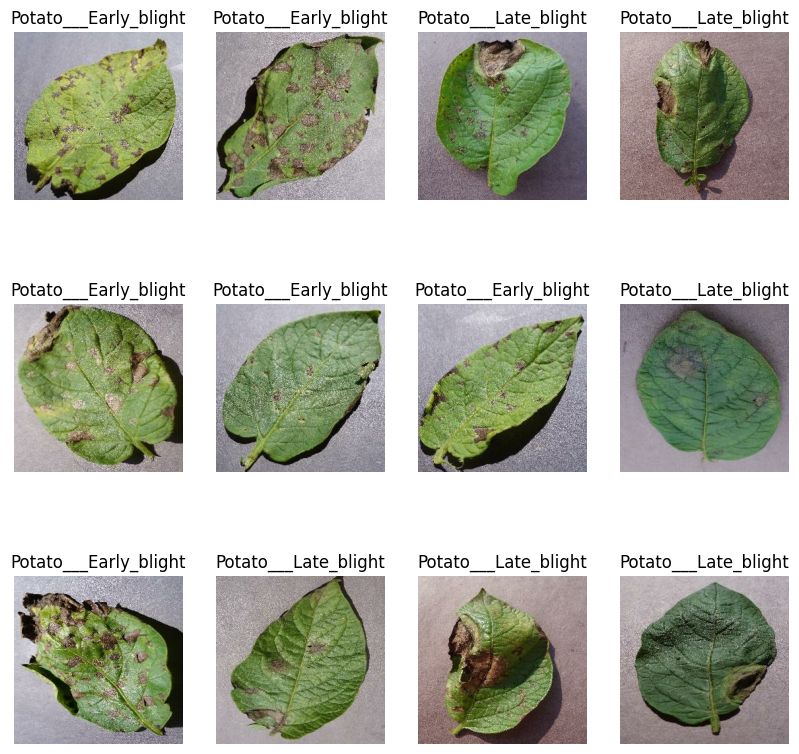

In [7]:
#Data Visualization
plt.figure(figsize=(10,10))
for image_batch , labels_batch in dataset.take(1):
    print(image_batch.numpy().shape)
    print(labels_batch.numpy())
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [8]:
#convert data into train test split 80% training 10% validation 10% Testing
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [9]:
train_ds = dataset.take(54)
len(train_ds)

54

In [10]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [11]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [12]:
val_ds = train_ds.take(6)
len(val_ds)

6

In [13]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [14]:
#function that return train, validation and test Split
def get_dataset_partitions_tf(ds ,train_split = 0.8 , val_split = 0.1 ,test_split =0.1 ,shuffle = True, shuffle_size= 1000):
    assert(train_split + test_split + val_split) == 1
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size , seed = 12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).take(val_size)

    return train_ds, val_ds, test_ds

In [15]:
train_ds ,val_ds, test_ds   = get_dataset_partitions_tf(dataset)

In [16]:
len(val_ds)

6

In [17]:
#now we do cache , shuffle , prefetch
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [18]:
for image_batch , labels_batch in dataset.take(1):
    print(image_batch.numpy())

[[[[117. 114. 125.]
   [120. 117. 128.]
   [114. 111. 122.]
   ...
   [147. 145. 159.]
   [143. 141. 155.]
   [140. 138. 152.]]

  [[110. 107. 118.]
   [ 84.  81.  92.]
   [104. 101. 112.]
   ...
   [151. 149. 163.]
   [147. 145. 159.]
   [144. 142. 156.]]

  [[151. 148. 159.]
   [ 88.  85.  96.]
   [122. 119. 130.]
   ...
   [151. 149. 163.]
   [148. 146. 160.]
   [146. 144. 158.]]

  ...

  [[135. 132. 149.]
   [114. 111. 128.]
   [143. 140. 157.]
   ...
   [182. 185. 194.]
   [180. 183. 192.]
   [181. 184. 193.]]

  [[143. 140. 157.]
   [154. 151. 168.]
   [159. 156. 173.]
   ...
   [180. 183. 192.]
   [179. 182. 191.]
   [186. 189. 198.]]

  [[149. 146. 163.]
   [155. 152. 169.]
   [136. 133. 150.]
   ...
   [174. 177. 186.]
   [177. 180. 189.]
   [196. 199. 208.]]]


 [[[190. 187. 196.]
   [179. 176. 185.]
   [176. 173. 182.]
   ...
   [196. 195. 203.]
   [190. 189. 197.]
   [190. 189. 197.]]

  [[189. 186. 195.]
   [191. 188. 197.]
   [191. 188. 197.]
   ...
   [200. 199. 207.]
 

In [19]:
#preprocessing during model creation RESCALING & RESIZING
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [20]:
#DATA AUGMENTATION
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [21]:
input_shape = (BATCH_SIZE , IMAGE_SIZE , IMAGE_SIZE , CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(64, kernel_size =(3,3) ,activation ='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, kernel_size =(3,3) ,activation ='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, kernel_size =(3,3) ,activation ='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3) ,activation ='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64,(3,3) ,activation ='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3) ,activation ='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes , activation = 'softmax'),
])

In [22]:
model.build(input_shape = input_shape)

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [24]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [26]:
history = model.fit(
    train_ds,
    batch_size = BATCH_SIZE,
    validation_data = val_ds,
    verbose = 1,
    epochs = EPOCHS
)

Epoch 1/50
54/54 [==============================] - 15s 280ms/step - loss: 0.9140 - accuracy: 0.4948 - val_loss: 0.8892 - val_accuracy: 0.5260
Epoch 2/50
54/54 [==============================] - 5s 86ms/step - loss: 0.7248 - accuracy: 0.6383 - val_loss: 0.5468 - val_accuracy: 0.7448
Epoch 3/50
54/54 [==============================] - 5s 90ms/step - loss: 0.4324 - accuracy: 0.8275 - val_loss: 0.3494 - val_accuracy: 0.8594
Epoch 4/50
54/54 [==============================] - 5s 87ms/step - loss: 0.3407 - accuracy: 0.8715 - val_loss: 0.2597 - val_accuracy: 0.8958
Epoch 5/50
54/54 [==============================] - 5s 87ms/step - loss: 0.2867 - accuracy: 0.8773 - val_loss: 0.2795 - val_accuracy: 0.8906
Epoch 6/50
54/54 [==============================] - 5s 88ms/step - loss: 0.2219 - accuracy: 0.9097 - val_loss: 0.3787 - val_accuracy: 0.8385
Epoch 7/50
54/54 [==============================] - 5s 86ms/step - loss: 0.2346 - accuracy: 0.9022 - val_loss: 0.2936 - val_accuracy: 0.8698
Epoch 8/50


In [27]:
len(test_ds)

6

In [29]:
score = model.evaluate(test_ds)

6/6 [==============================] - 0s 35ms/step - loss: 0.0180 - accuracy: 0.9948


In [31]:
score

[0.01802372746169567, 0.9947916865348816]

In [32]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [33]:
history.history['accuracy']

[0.4947916567325592,
 0.6383101940155029,
 0.8275462985038757,
 0.8715277910232544,
 0.8773148059844971,
 0.9097222089767456,
 0.9021990895271301,
 0.9351851940155029,
 0.9253472089767456,
 0.9456018805503845,
 0.9502314925193787,
 0.9739583134651184,
 0.9675925970077515,
 0.9612268805503845,
 0.9809027910232544,
 0.9820601940155029,
 0.9855324029922485,
 0.9791666865348816,
 0.9739583134651184,
 0.9890046119689941,
 0.9895833134651184,
 0.9872685074806213,
 0.9791666865348816,
 0.9826388955116272,
 0.9751157164573669,
 0.984375,
 0.9878472089767456,
 0.9884259104728699,
 0.9826388955116272,
 0.9768518805503845,
 0.9756944179534912,
 0.9774305820465088,
 0.9884259104728699,
 0.9901620149612427,
 0.9901620149612427,
 0.9924768805503845,
 0.9826388955116272,
 0.9918981194496155,
 0.9849537014961243,
 0.9878472089767456,
 0.9895833134651184,
 0.984375,
 0.9953703880310059,
 0.9756944179534912,
 0.9826388955116272,
 0.9878472089767456,
 0.9907407164573669,
 0.9785879850387573,
 0.987268507

In [34]:
history.history['loss'][:5]

[0.9139735698699951,
 0.7247970700263977,
 0.43237632513046265,
 0.3406642973423004,
 0.286744624376297]

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

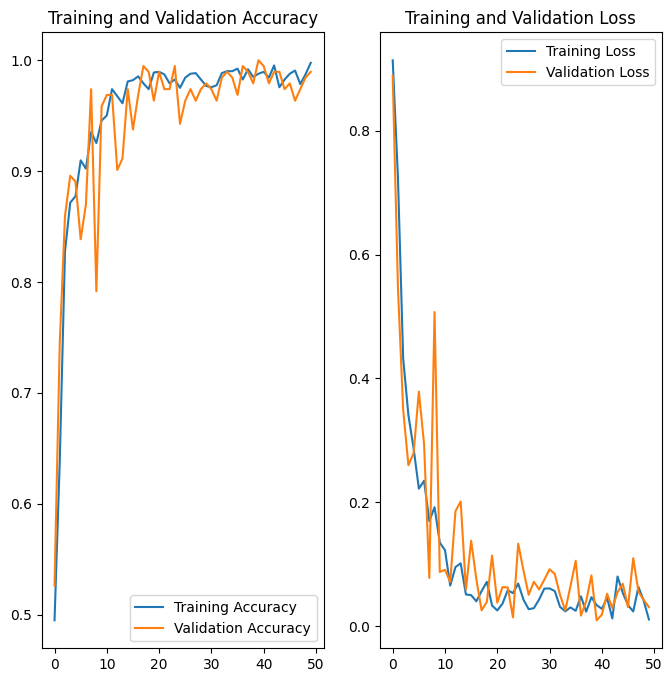

In [36]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___healthy
1/1 [==============================] - 0s 29ms/step
predicted label: Potato___healthy


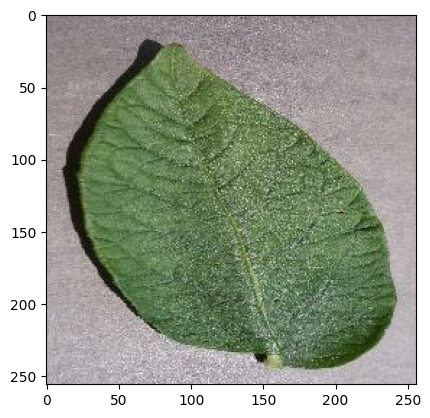

In [38]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [39]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 51ms/step


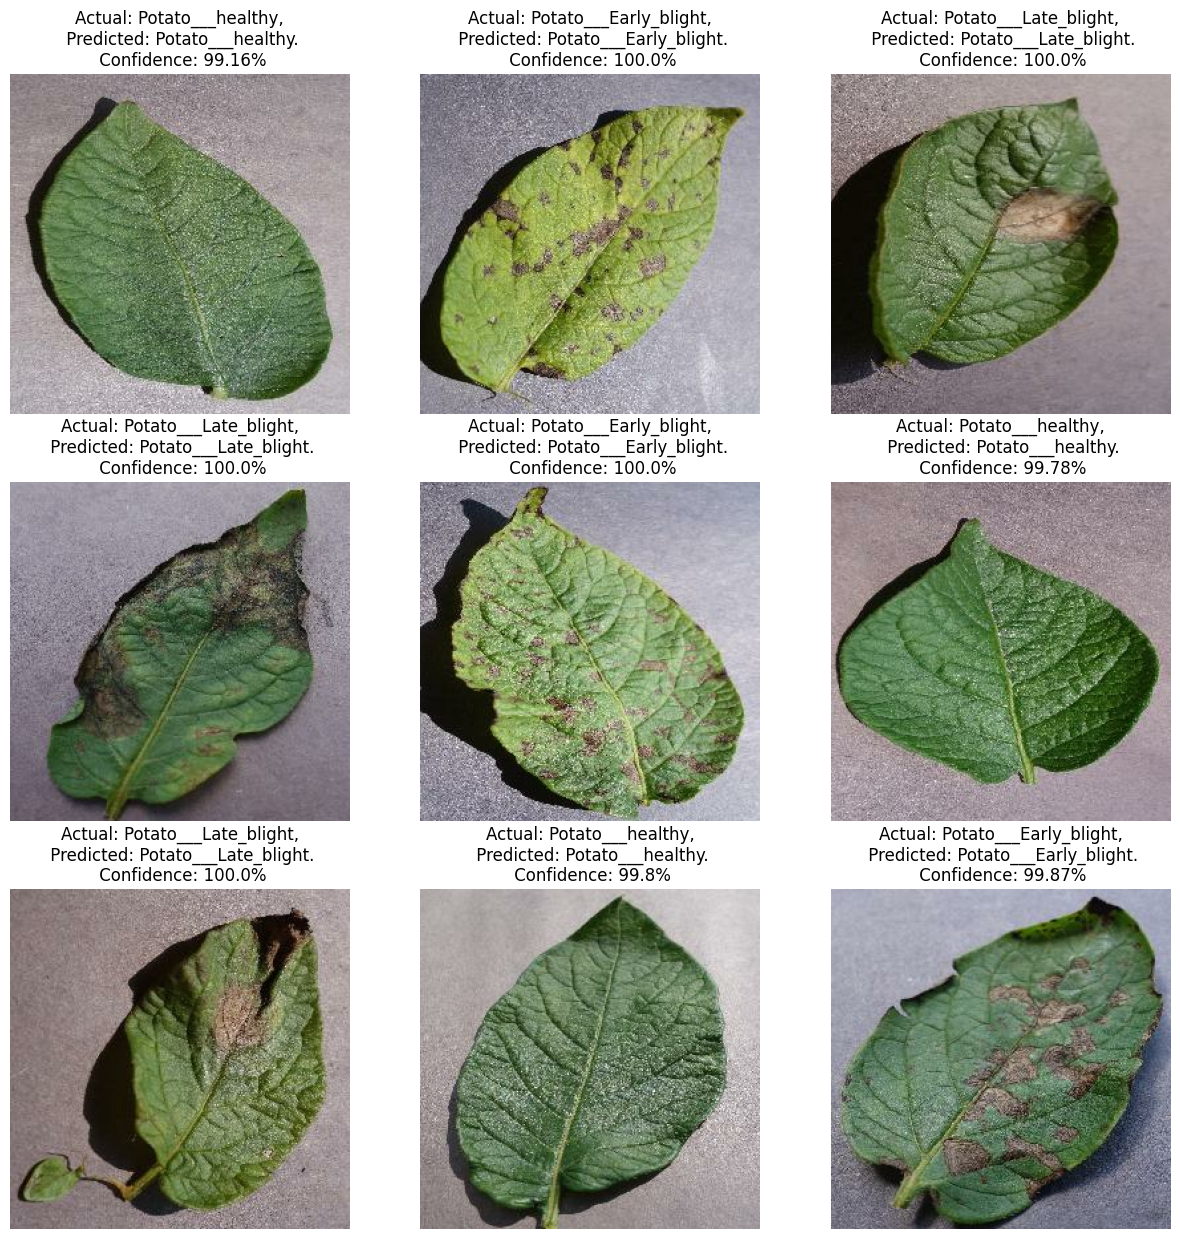

In [40]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [41]:
#save the model
import os
model_version=max([int(i) for i in os.listdir("/content/drive/MyDrive/models") + [0]])+1
model.save(f"/content/drive/MyDrive/models/{model_version}")